In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils.Preprocess import Preprocess
from utils.CalculateDissimilarity import CalculateDissimilarity
from utils.GenerateSyntheticData import GenerateSyntheticData
from utils.GWOptimalTransfer import GWOptimalTransfer
from utils.PlotFigures import PlotFigures
import ot
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from utils.extract_paths import extract_paths
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
from run import run
from collections import OrderedDict
import itertools
from tqdm import tqdm
import time
from run import run_tmp

In [15]:
def plot_optimal_P_heatmap(optimal_P, min_error, min_emotions):
    fig = plt.figure(figsize=(6,5))

    ax = fig.add_subplot(1,1,1)
    sns.heatmap(optimal_P, cmap='Reds', xticklabels=min_emotions, yticklabels=min_emotions)
    ax.set_title(f'min_error: {min_error}')
    plt.show()

def calcurate_error(optimal_P):
    non_zero_positions = np.argwhere(optimal_P != 0)
    if non_zero_positions.size == 0:
        return 100000000
    else:
        position_error = sum([np.abs(position[0]-position[1]) for position in non_zero_positions])
        return position_error
def swap_dict_items(d, key1, key2):
    # OrderedDictを使用して順序を保持
    d = OrderedDict(d)
    # key1とkey2の位置を取得
    keys = list(d.keys())
    index1, index2 = keys.index(key1), keys.index(key2)
    # key1とkey2の値を取得
    value1, value2 = d[key1], d[key2]
    # key1とkey2を削除
    del d[key1]
    del d[key2]
    # key1とkey2を新しい位置に挿入
    if index1 < index2:
        d.update({key2: value2})
        d.move_to_end(key2, last=False)
        d.update({key1: value1})
        d.move_to_end(key1, last=False)
    else:
        d.update({key1: value1})
        d.move_to_end(key1, last=False)
        d.update({key2: value2})
        d.move_to_end(key2, last=False)
    return d

In [33]:
gen_syn = False
non_al_folder_path = './qualia_rawdata/single_subject/non_alcohol/'
al_folder_path = './qualia_rawdata/single_subject/alcohol/'
plot_dim = 3
max_iter=500
comparing_pairs=('non_al', 'al')
qualia_color = {
    'empatic_pain': 'orange',
    'guilt': 'black',
    'fear': 'violet',
    'anger': 'red',
    'envy': 'purple',
    'sadness': 'blue',
    'surprise': 'gray',
    'joy': 'cyan',
    'amusement': 'brown',
    'romance': 'pink',
    'aesthetic_appreciation': 'yellow',
    'awe': 'green',
}


## マルチ被験者の際のカラム順序最適化

In [4]:
first_qualia_paths, second_qualia_paths = extract_paths(
    non_al_folder_path=non_al_folder_path,
    al_folder_path=al_folder_path,
    comparing_pairs=comparing_pairs
)

all_original_embeddings_list = list()
all_dissimilarity_matrices = list()
attributes = ['non_alcohol', 'alcohol']
subjects = list()
all_preprocessed_dfs=list()

for paths in [first_qualia_paths, second_qualia_paths]:
    preprocessed_dfs = list()
    for path in paths:
        #pathで指定された被験者の実験データを前処理して出力
        preprocess = Preprocess(path=path)
        subject_name = preprocess.return_subject_name()
        if paths == first_qualia_paths:
            subjects.append(subject_name)
        sim_list, comparison_video_pairs = preprocess.extract_cols()
        preprocessed_df = preprocess.output_data(sim_list, comparison_video_pairs)
        #保存
        preprocessed_dfs.append(preprocessed_df)
    all_preprocessed_dfs.append(preprocessed_dfs)

## ここから非類似度行列に関する調査

In [ ]:
#gw最適輸送の実行
X_embeddings = all_original_embeddings[0]
Y_embeddings = all_original_embeddings[1]
gwot = GWOptimalTransfer(
    X_embeddings=X_embeddings,
    Y_embeddings=Y_embeddings,
    qualia_color=qualia_color)
X_embeddings_combined, Y_embeddings_combined = gwot.reshape_embeddings()
X_embeddings_combined.shape

(3, 60)

In [ ]:
#輸送行列のカラム
emotions = list(qualia_color.keys())
transformer_columns = [f'{subject}_{emotion}' for emotion in emotions for subject in subjects]
len(transformer_columns)

60

In [ ]:
optimal_P = gwot.gromov_wasserstein(
    X_embeddings_combined=X_embeddings_combined,
    Y_embeddings_combined=Y_embeddings_combined,
    max_iter=max_iter)


<Axes: >

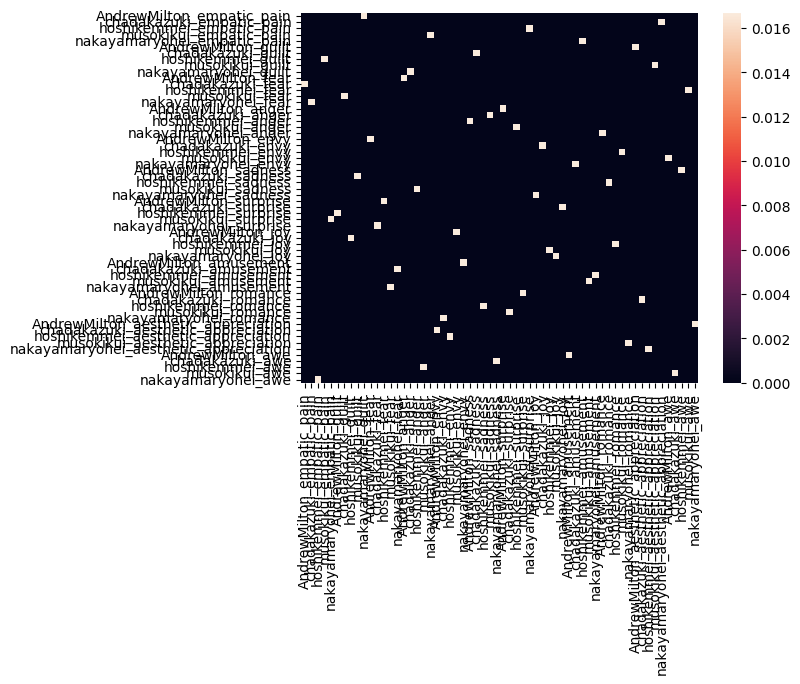

In [ ]:
sns.heatmap(optimal_P, xticklabels=transformer_columns, yticklabels=transformer_columns)

100%|██████████| 66/66 [01:36<00:00,  1.47s/it]


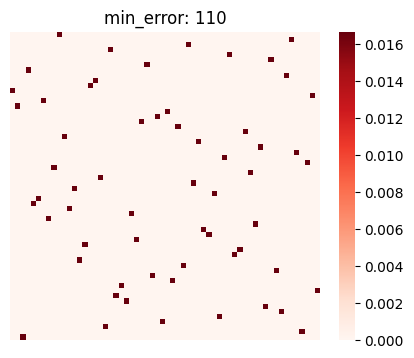

In [ ]:
#ここから並び替え試行
pairs = list(itertools.combinations(emotions, 2))
def improve_by_swapping(pairs, max_iter=2):
    min_qualia_color = qualia_color
    min_optimal_P = optimal_P
    min_columns = list()
    min_error = 110

    #about the order of emotions
    for iter in range(max_iter):
        for pair in tqdm(pairs):
            tmp_qualia_color = dict(swap_dict_items(min_qualia_color, pair[0], pair[1]))

            subjects, tmp_optimal_P = run(
                non_al_folder_path=non_al_folder_path,
                al_folder_path=al_folder_path,
                plot_dim=2,
                generate_syn=False,
                qualia_color=tmp_qualia_color,
                max_iter=500,
                comparing_pairs=('non_al', 'al')
            )
            tmp_error = calcurate_error(optimal_P=tmp_optimal_P)
            if tmp_error < min_error:
                min_qualia_color = tmp_qualia_color
                min_emotions = list(min_qualia_color.keys())
                min_columns = [f'{subject}_{emotion}' for emotion in min_emotions for subject in subjects]
                min_error = tmp_error
                min_optimal_P = tmp_optimal_P
    plot_optimal_P_heatmap(optimal_P=min_optimal_P, min_error=min_error,min_emotions =min_columns)
    return min_qualia_color, min_optimal_P
min_qualia_color, min_optimal_P = improve_by_swapping(pairs)


In [ ]:
#ここから並び替え試行
pairs = list(itertools.combinations(emotions, 2))
def improve_by_swapping(pairs, max_iter=2):
    min_qualia_color = qualia_color
    min_optimal_P = optimal_P
    min_columns = list()
    min_error = 110

    #about the order of emotions
    for iter in range(max_iter):
        for pair in tqdm(pairs):
            tmp_qualia_color = dict(swap_dict_items(min_qualia_color, pair[0], pair[1]))

            subjects, tmp_optimal_P = run(
                non_al_folder_path=non_al_folder_path,
                al_folder_path=al_folder_path,
                plot_dim=2,
                generate_syn=False,
                qualia_color=tmp_qualia_color,
                max_iter=500,
                comparing_pairs=('non_al', 'al')
            )
            tmp_error = calcurate_error(optimal_P=tmp_optimal_P)
            if tmp_error < min_error:
                min_qualia_color = tmp_qualia_color
                min_emotions = list(min_qualia_color.keys())
                min_columns = [f'{subject}_{emotion}' for emotion in min_emotions for subject in subjects]
                min_error = tmp_error
                min_optimal_P = tmp_optimal_P


    #about the order of subject
    #state; min_qualia_color, min_optimal_P, min_error


    plot_optimal_P_heatmap(optimal_P=min_optimal_P, min_error=min_error,min_emotions =min_columns)
    return min_qualia_color, min_optimal_P
min_qualia_color, min_optimal_P = improve_by_swapping(pairs)


## run関数のリファクタリグ

In [29]:
from run import process_of_preprocess, process_of_dissimilarity, process_of_gwot
plot_dim = 2
subjects, all_preprocessed_dfs = process_of_preprocess(
    non_al_folder_path=non_al_folder_path,
    al_folder_path=al_folder_path,
    comparing_pairs=comparing_pairs,
    generate_syn=False
)
all_dissimilarity_matrices, all_original_embeddings = process_of_dissimilarity(
    all_preprocessed_dfs=all_preprocessed_dfs,
    qualia_color=qualia_color,
    plot_dim=plot_dim
)
print(all_dissimilarity_matrices.shape, all_original_embeddings.shape)
optimal_P, optimal_Q, Y_mapped_embeddings = process_of_gwot(
    all_original_embeddings=all_original_embeddings,
    qualia_color=qualia_color,
    max_iter=500,
    plot_optimal_flag=False
)
print(optimal_P.shape)

(2, 1, 12, 12) (2, 1, 12, 2)
(12, 12)


In [37]:
['a'] + ['b']

['a', 'b']

In [40]:
posi_emotions = ['romance', 'aesthetic_appreciation', 'surprise', 'joy', 'amusement']
nega_emotions = ['empatic_pain',  'guilt', 'fear', 'anger', 'awe', 'envy', 'sadness']
posi_permutations = list(itertools.permutations(posi_emotions))
nega_permutations = list(itertools.permutations(nega_emotions))
len(posi_permutations), len(nega_permutations)
# Combine permutations of positive and negative emotions
all_combinations = [list(p + n) for p in posi_permutations for n in nega_permutations]

In [ ]:
min_qualia_color = qualia_color
min_optimal_P = optimal_P
min_error = calcurate_error(optimal_P=optimal_P)
min_all_original_embeddings = all_original_embeddings
min_columns = [f'{subject}_{emotion}' for emotion in emotions for subject in subjects]

for emotion in all_combinations:
    tmp_qualia_color = {key: qualia_color[key] for key in emotion}

    all_dissimilarity_matrices, tmp_all_original_embeddings = process_of_dissimilarity(
        all_preprocessed_dfs=all_preprocessed_dfs,
        qualia_color=tmp_qualia_color,
        plot_dim=plot_dim
    )

    tmp_optimal_P = process_of_gwot(
        all_original_embeddings=tmp_all_original_embeddings,
        qualia_color=tmp_qualia_color,
        max_iter=max_iter,
        plot_optimal_flag=False
    )

    tmp_error = calcurate_error(optimal_P=tmp_optimal_P)
    if tmp_error < min_error:
        min_qualia_color = tmp_qualia_color
        min_emotions = list(min_qualia_color.keys())
        min_columns = [f'{subject}_{emotion}' for emotion in min_emotions for subject in subjects]
        min_error = tmp_error
        min_optimal_P = tmp_optimal_P
        min_all_original_embeddings = tmp_all_original_embeddings

  0%|          | 0/66 [00:00<?, ?it/s]

100%|██████████| 66/66 [00:23<00:00,  2.80it/s]


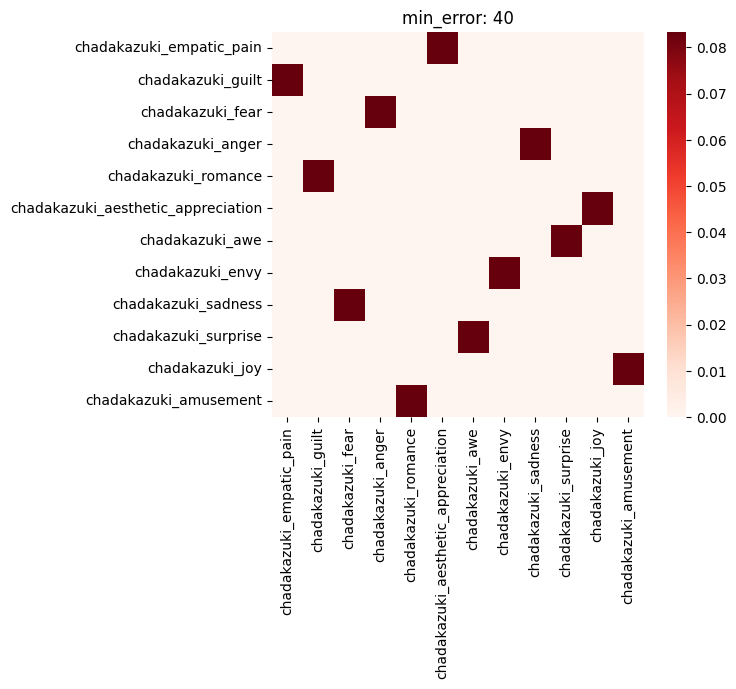

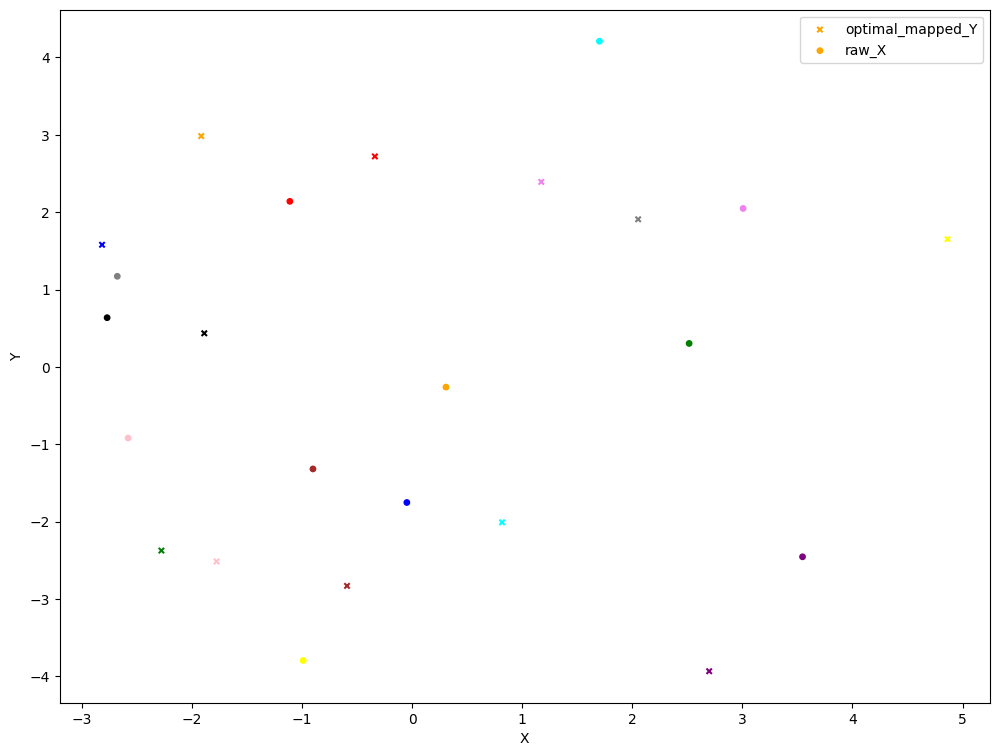

In [32]:
#ここから並び替え試行
emotions = list(qualia_color.keys())
pairs = list(itertools.combinations(emotions, 2))
def improve_by_swapping(pairs, subjects, swapping_trials=10):
    min_qualia_color = qualia_color
    min_optimal_P = optimal_P
    min_error = calcurate_error(optimal_P=optimal_P)
    min_all_original_embeddings = all_original_embeddings
    min_columns = [f'{subject}_{emotion}' for emotion in emotions for subject in subjects]

    #about the order of emotions
    for pair in tqdm(pairs):
        tmp_qualia_color = dict(swap_dict_items(min_qualia_color, pair[0], pair[1]))

        all_dissimilarity_matrices, tmp_all_original_embeddings = process_of_dissimilarity(
            all_preprocessed_dfs=all_preprocessed_dfs,
            qualia_color=tmp_qualia_color,
            plot_dim=plot_dim
        )

        tmp_optimal_P = process_of_gwot(
            all_original_embeddings=tmp_all_original_embeddings,
            qualia_color=tmp_qualia_color,
            max_iter=max_iter,
            plot_optimal_flag=False
        )

        tmp_error = calcurate_error(optimal_P=tmp_optimal_P)
        if tmp_error < min_error:
            min_qualia_color = tmp_qualia_color
            min_emotions = list(min_qualia_color.keys())
            min_columns = [f'{subject}_{emotion}' for emotion in min_emotions for subject in subjects]
            min_error = tmp_error
            min_optimal_P = tmp_optimal_P
            min_all_original_embeddings = tmp_all_original_embeddings

    return min_qualia_color, min_optimal_P, min_all_original_embeddings, min_columns, min_error

min_qualia_color, min_optimal_P, min_all_original_embeddings, min_columns, min_error = improve_by_swapping(pairs, subjects)

plot_optimal_P_heatmap(optimal_P=min_optimal_P, min_error=min_error,min_emotions =min_columns)
optimal_P, optimal_Q, Y_mapped_embeddings = process_of_gwot(
    all_original_embeddings=min_all_original_embeddings,
    qualia_color=min_qualia_color,
    max_iter=500,
    plot_optimal_flag=True
)

<Axes: >

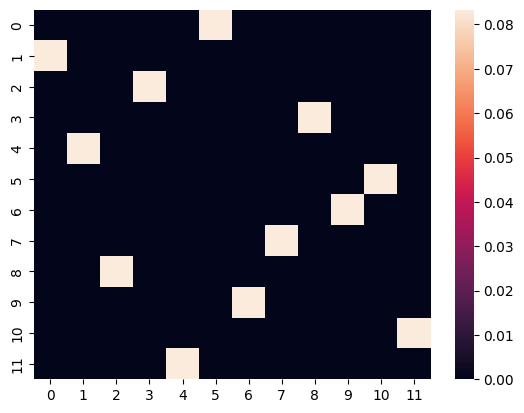

In [31]:
sns.heatmap(optimal_P)